# Statisical Genetics Final Project

## Pedigree file correction

First we update the fam file with the cases and controls

In [2]:
import pandas as pd

fam = pd.read_csv("GWAS_data.fam", sep="\t", header=None)
csv = pd.read_csv("Clinical_Asthma.csv")

In [129]:
csv

,ID,FamID,CAD,sex,age,tg,hdl,ldl,Asthma_1Control_2Case
0,10002,10002,1,1,60,NaN,NaN,NaN,2
1,10004,10004,1,2,50,55.0,23.0,75.0,2
2,10005,10005,1,1,55,105.0,37.0,69.0,1
3,10007,10007,1,1,52,314.0,54.0,108.0,1
4,10008,10008,1,1,58,161.0,40.0,94.0,2
...,...,...,...,...,...,...,...,...,...
1396,11591,11591,0,2,59,34.0,44.0,89.0,1
1397,11592,11592,1,1,45,69.0,101.0,77.0,1
1398,11593,11593,1,1,59,77.0,27.0,41.0,2
1399,11594,11594,1,1,30,NaN,NaN,NaN,1


In [133]:
fam.iloc[:,5] = csv["Asthma_1Control_2Case"]
fam

,0,1,2,3,4,5
0,10002,1,0,0,1,2
1,10004,1,0,0,2,2
2,10005,1,0,0,1,1
3,10007,1,0,0,1,1
4,10008,1,0,0,1,2
...,...,...,...,...,...,...
1396,11591,1,0,0,2,1
1397,11592,1,0,0,1,1
1398,11593,1,0,0,1,2
1399,11594,1,0,0,1,1


In [38]:
fam.to_csv("GWAS_data.fam", sep="\t", index=False, header=False)

In [6]:
## Balance check between case & controls
fam.iloc[:,5].value_counts()

5
2    721
1    680
Name: count, dtype: int64

## Quality Control

We make plink bed files

```bash
plink --bfile GWAS_data --make-bed --out data
```

We compute the statistics
```bash
plink --bfile data --missing --freq --hardy --het --out stats
```
We read the computed statistics and then we plot them to choose the filter thresholds. The thresholds are arbitrary, thus we choose them based on the graphs (except for HWE, where we choose a $p$-value threshold of $1\times10^{-6}$) and draw them as dashed lines.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

imiss = pd.read_csv('stats.imiss', sep='\\s+')
lmiss = pd.read_csv('stats.lmiss', sep='\\s+')
maf = pd.read_csv('stats.frq', sep='\\s+')
hwe =pd.read_csv('stats.hwe', sep='\\s+')
ibc = pd.read_csv('stats.ibc', sep='\\s+')
het =pd.read_csv('stats.het', sep='\\s+')

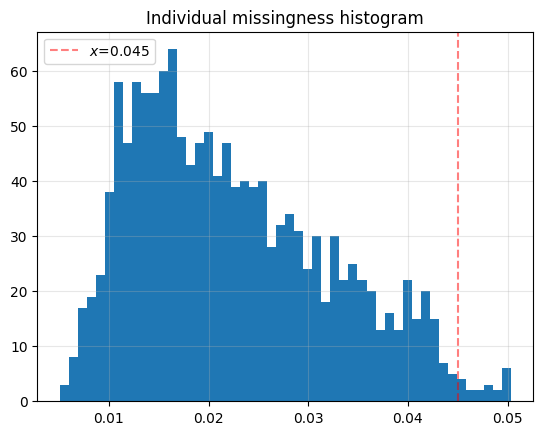

In [4]:
imiss.F_MISS.hist(bins=50)
plt.grid(alpha=0.3)
plt.axvline(0.045, color='red', alpha=0.5, linestyle='--', label = '$x$=0.045')
plt.title('Individual missingness histogram')
plt.legend()
plt.savefig('Plots/imiss.png', dpi=300)

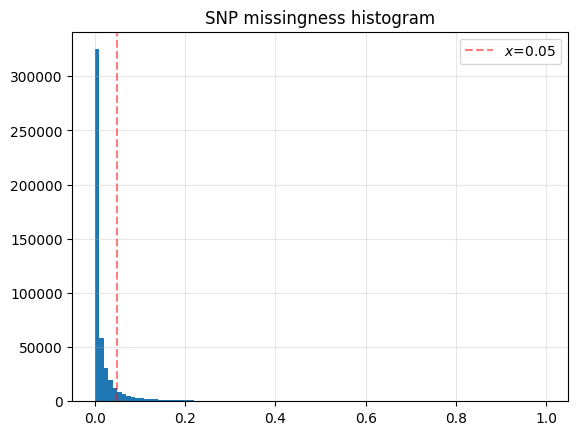

In [5]:
lmiss.F_MISS.hist(bins=100)
plt.grid(alpha=0.3)
plt.axvline(x=0.05, color='red', alpha=0.5, linestyle='--', label = '$x$=0.05')
plt.title('SNP missingness histogram')
plt.legend()
plt.savefig('Plots/lmiss.png', dpi=300)

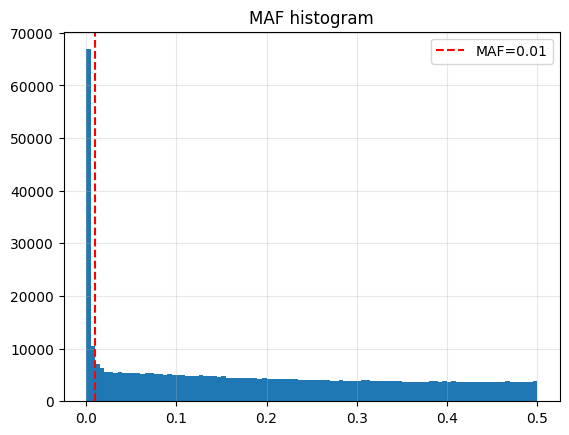

In [6]:
maf.MAF.hist(bins=100)
plt.grid(alpha=0.3)
plt.axvline(0.01, color='red', linestyle='--', label = 'MAF=0.01')
plt.title('MAF histogram')
plt.legend()
plt.savefig('Plots/maf.png', dpi=300)

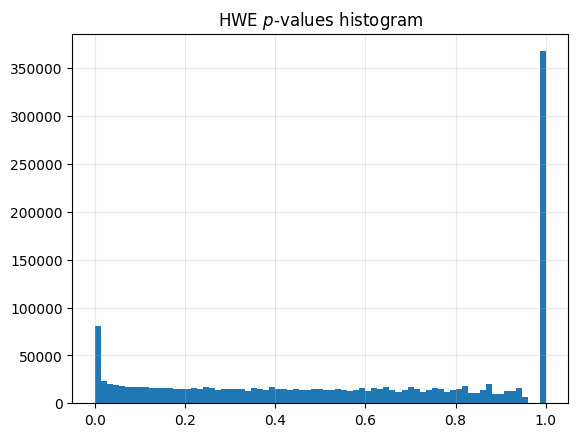

In [7]:
hwe.P.hist(bins=75)
plt.grid(alpha=0.3)
plt.title('HWE $p$-values histogram')
plt.savefig('Plots/hwe.png', dpi=300)

We compute the heterozygosity rate with
$$\frac{N(NM)-O(HOM)}{N(NM)}$$
where $N(NM)$ is the number of nonmissing genotypes and $O(HOM)$ the observed humber of homozygous genotypes.
Making the assumption it follows a normal distribution, more than 99% of the values are going to be between
$\mu\pm\sigma^2$.

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/var/folders/zy/5y2l_rkj4f32jtwxywyysp2m0000gn/T/ipykernel_2329/1070171888.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.axvline(het.rate.mean() + 3 * het.rate.std(), color='red', alpha=0.5, linestyle='--', label = '$x=\hat{\mu}\pm3\hat{\sigma}^2$')


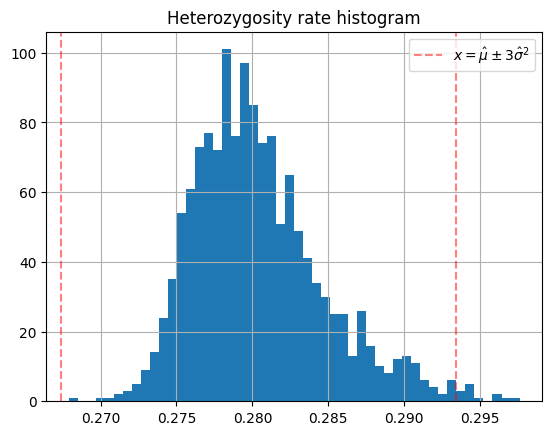

In [8]:
het['rate'] = (het['N(NM)'] - het['O(HOM)'])/het['N(NM)']
het.rate.hist(bins=50)
plt.axvline(het.rate.mean() + 3 * het.rate.std(), color='red', alpha=0.5, linestyle='--', label = '$x=\hat{\mu}\pm3\hat{\sigma}^2$')
plt.axvline(het.rate.mean() - 3 * het.rate.std(), color='red', alpha=0.5, linestyle='--')
plt.title('Heterozygosity rate histogram')
plt.legend()
plt.savefig('Plots/rate.png', dpi=300)


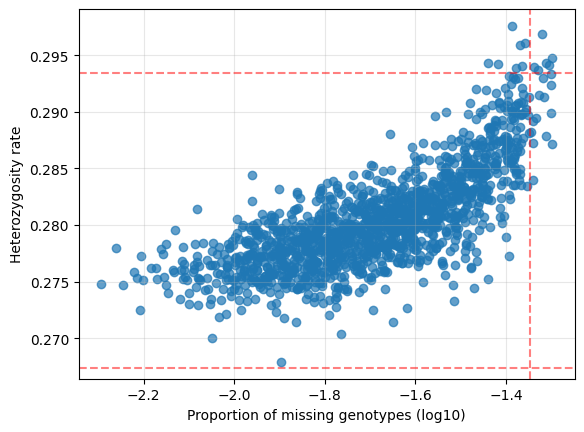

In [9]:
# Plot that compares individuals qc thresholds
imiss['F_log'] = np.log10(imiss.F_MISS)
plt.scatter(imiss.F_log, het.rate, alpha=0.7)
plt.axhline(het.rate.mean() + 3 * het.rate.std(), color='red', alpha=0.5, linestyle='--')
plt.axhline(het.rate.mean() - 3 * het.rate.std(), color='red', alpha=0.5, linestyle='--')
plt.axvline(np.log10(0.045), color='red', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.ylabel('Heterozygosity rate')
plt.xlabel('Proportion of missing genotypes (log10)')
plt.savefig('Plots/het_vs_imiss.png', dpi=300)

In [181]:
# Samples failing the het QC
het_fail = het[(het.rate > het.rate.mean() + 3 * het.rate.std()) | (het.rate < het.rate.mean() - 3 * het.rate.std())]
het_fail.FID.to_csv('het_fail.txt', index=False, header=False)

We perform the QC following the thresholds 
```bash
plink --bfile data --maf 0.01 --geno 0.05 --mind 0.045 --hwe 0.000001 --remove-fam het_fail.txt --make-bed --out qc
```

From the original 500,000 variants, we keep 382,054. From the 1,401 samples, we keep 1,375

## Cryptic relatedness


To compute the IBD, we first perform an LD-pruning. This will be also used to compute the PCs from the PCA

```bash
## LD pruning
plink --bfile qc  --indep-pairwise 50 5 0.2 --out ld_qc   
plink --bfile qc --extract ld_qc.prune.in --make-bed --out pruned

## IBD check
plink --bfile pruned --genome --out ibd
```

In [11]:
ibd = pd.read_csv('ibd.genome', sep='\\s+')
ibd

,FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
0,10002,1,10004,1,UN,NaN,0.9351,0.0649,0.0000,0.0324,1,0.764144,0.9992,2.2378
1,10002,1,10005,1,UN,NaN,0.9576,0.0424,0.0000,0.0212,0,0.764998,0.9983,2.2189
2,10002,1,10007,1,UN,NaN,0.9382,0.0618,0.0000,0.0309,0,0.765583,0.9961,2.1983
3,10002,1,10008,1,UN,NaN,0.9358,0.0642,0.0000,0.0321,1,0.765979,0.9944,2.1878
4,10002,1,10009,1,UN,NaN,0.9564,0.0436,0.0000,0.0218,1,0.763529,0.8155,2.0642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944620,11592,1,11594,1,UN,NaN,0.9535,0.0465,0.0000,0.0233,-1,0.762197,0.5965,2.0171
944621,11592,1,11596,1,UN,NaN,0.9768,0.0179,0.0054,0.0143,0,0.764722,0.9188,2.1008
944622,11593,1,11594,1,UN,NaN,0.9544,0.0456,0.0000,0.0228,0,0.763463,0.9991,2.2346
944623,11593,1,11596,1,UN,NaN,0.9623,0.0335,0.0042,0.0210,1,0.765859,0.9322,2.1081


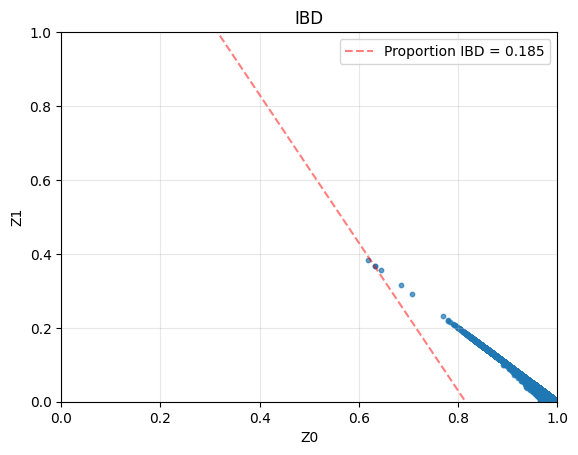

In [12]:
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(ibd.Z0, ibd.Z1, alpha=0.7, s=10)
plt.grid(alpha=0.3)
x = np.linspace(0, 1, 100)
y = -2*x + 163/100 ## Treshold for proportion IBD 0.185
plt.plot(x,y, color='red', alpha=0.5, linestyle='--', label='Proportion IBD = 0.185')
plt.xlabel('Z0')
plt.ylabel('Z1')
plt.title('IBD')
plt.legend()
plt.savefig('Plots/ibd.png', dpi=300)

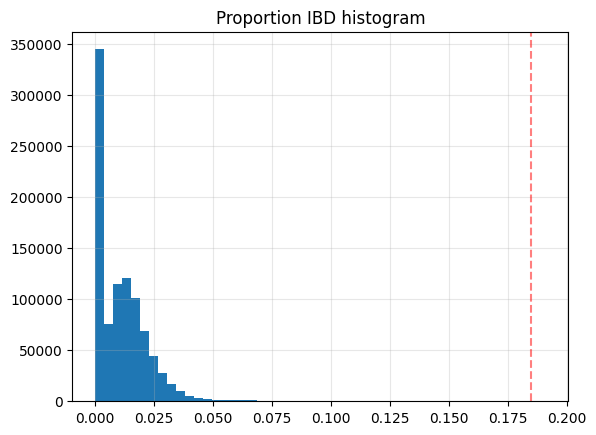

In [13]:
ibd.PI_HAT.hist(bins=50)
plt.grid(alpha=0.3)
plt.axvline(0.185, color='red', alpha=0.5, linestyle='--')
plt.title('Proportion IBD histogram')
plt.savefig('Plots/ibd_hist.png', dpi=300)

We exclude one sample of the pairs with proportion IBD > 0.185:

```bash
plink --bfile pruned --genome --min 0.185 --out related
```

In [175]:
!cat related.genome

   FID1 IID1   FID2 IID2 RT    EZ      Z0      Z1      Z2  PI_HAT PHE       DST     PPC   RATIO
  10347   1  10447   1 UN    NA  0.6178  0.3822  0.0000  0.1911   0  0.780480  1.0000  3.0705


Since we just have one pair, we manually check the misingness to keep the one that has the lowest missingness

In [176]:
!grep 10347 stats.imiss
!echo '\n'
!grep 10447 stats.imiss

  10347    1          N    20256   500000  0.04051
  11262    1          N    10347   500000  0.02069


  10447    1          N    18935   500000  0.03787


The sample with the FID 10447 is the one we are keeping
```bash
touch related.txt ## We write the FID in the terminal
plink --bfile qc --remove-fam related.txt --make-bed --out qc_final
plink --bfile pruned --remove-fam related.txt --make-bed --out pruned_final
```

## PCA

We compute the PCs and choose how many to keep based on the elbow plot

```bash
plink --bfile pruned_final --pca 'header' --out pca
```

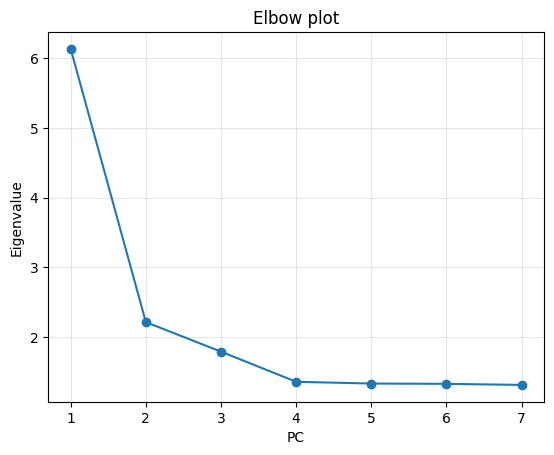

In [14]:
eigenvals = pd.read_csv('pca.eigenval', header=None)
eigenvals.index = eigenvals.index + 1
plt.plot(eigenvals[:7], marker='o')
plt.grid(alpha=0.3)
plt.ylabel('Eigenvalue')
plt.xlabel('PC')
plt.title('Elbow plot')
plt.savefig('Plots/elbow.png', dpi=300)

In [16]:
pruned = pd.read_csv('pruned_final.fam', sep='\\s+', header=None)
pca = pd.read_csv('pca.eigenvec', sep='\\s+')
pca['Phenotype'] = pruned.iloc[:,5]
pca

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Phenotype
0,10002,1,0.010622,-0.019708,-0.000968,-0.015180,-0.028861,0.061959,-0.041192,-0.000290,...,0.003319,-0.035749,-0.021902,-0.008621,-0.016814,-0.008368,-0.002673,-0.033697,-0.020062,2
1,10004,1,-0.011390,0.003167,-0.009742,-0.007170,0.005146,0.007745,0.001465,-0.039716,...,0.020830,0.033591,0.039445,0.061568,0.025238,-0.023004,0.016150,0.045722,0.018477,2
2,10005,1,-0.016076,0.007812,0.021501,0.021494,-0.017418,-0.003204,-0.001178,-0.014044,...,-0.011248,0.045166,-0.000704,0.019956,-0.002039,-0.034345,-0.000683,0.014068,0.023224,1
3,10007,1,-0.010833,-0.010266,0.007993,-0.008843,-0.012555,-0.027863,0.015142,0.019861,...,0.007319,0.021477,-0.016935,0.043146,0.011794,-0.000010,0.013464,-0.016521,0.017837,1
4,10008,1,-0.016318,0.000926,0.013182,0.008431,0.000395,-0.025256,-0.011626,-0.045288,...,0.022652,-0.009592,0.023802,0.002863,0.023207,0.002861,0.053511,0.018130,-0.002929,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,11591,1,-0.016729,0.003988,0.011666,-0.005225,0.045043,0.029872,-0.001005,-0.009348,...,-0.003151,0.002687,0.003949,-0.022024,0.038177,-0.005146,0.014120,-0.028627,0.000306,1
1370,11592,1,-0.016319,0.005391,-0.070269,0.021226,-0.019021,0.024129,0.053517,-0.015282,...,-0.046552,0.025109,-0.003441,0.034078,-0.008429,0.026057,0.022054,0.027734,0.023648,1
1371,11593,1,-0.017488,0.006322,0.002771,-0.022276,-0.032657,0.014362,0.005914,0.001097,...,-0.021755,-0.021362,0.003496,-0.000677,-0.015808,-0.002049,0.004103,0.029106,-0.004654,2
1372,11594,1,-0.013147,0.006308,0.005023,0.042728,0.025542,0.012672,-0.036492,-0.001474,...,-0.018361,-0.056197,-0.030390,-0.012873,0.011724,-0.017111,-0.068490,0.084154,-0.001155,1


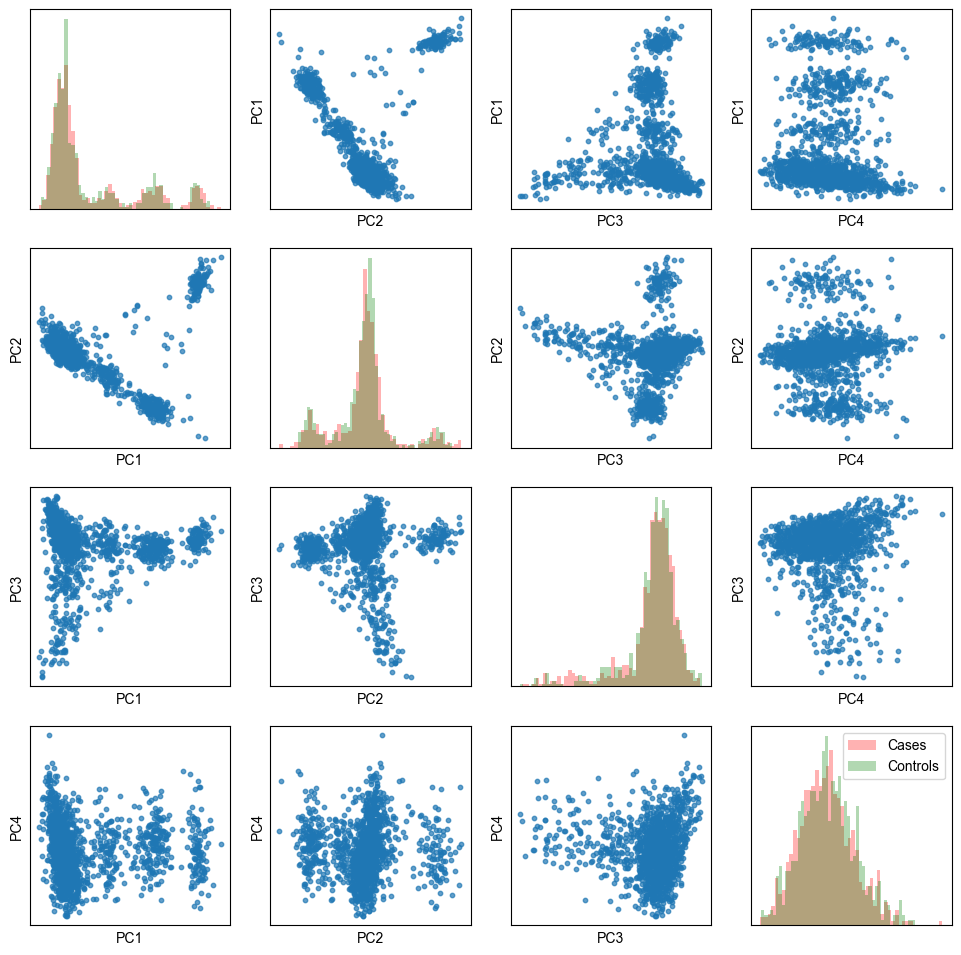

In [25]:
n_max = 5
plt.figure(figsize=(15,15))
for i in range(1, n_max):
    for j in range(1, n_max):
        plt.subplot(n_max, n_max, j * n_max + i)
        if i==j:
            #pca.iloc[:,i+1].hist(bins=50)
            plt.hist(pca.query('Phenotype==2').iloc[:,i+1], label='Cases', bins=50, density=True, alpha=0.3, color='red')
            plt.hist(pca.query('Phenotype==1').iloc[:,i+1], label='Controls', bins=50, density=True, alpha=0.3, color='green')

        else:
            plt.scatter(pca.iloc[:,i+1], pca.iloc[:,j+1], s=10, alpha=0.7)
            plt.grid(alpha=0.3)
            plt.xlabel('PC'+str(i))
            plt.ylabel('PC'+str(j))

        ## Erases axis labels
        plt.xticks([])
        plt.yticks([])
plt.legend()
plt.savefig('Plots/pca.png', dpi=300)
        

## Genome-Wide Association Study

We choose to keep 4 PCs. We perform a logistic regression using an additive model

```bash
plink --bfile qc_final --logistic --covar pca.eigenvec --covar-number 3-6 --out gwas
```


In [20]:
gwas = pd.read_csv('gwas.assoc.logistic', sep='\\s+')
gwas

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
0,1,rs12565286,721290,G,ADD,1359,0.87650,-0.7644,0.4446
1,1,rs12565286,721290,G,PC3,1359,0.05326,-1.4510,0.1468
2,1,rs12565286,721290,G,PC4,1359,0.13730,-0.9887,0.3228
3,1,rs12565286,721290,G,PC5,1359,0.46580,-0.3788,0.7048
4,1,rs12565286,721290,G,PC6,1359,2.77900,0.4934,0.6217
...,...,...,...,...,...,...,...,...,...
1910265,22,rs28729663,51219006,A,ADD,1370,0.96440,-0.3229,0.7468
1910266,22,rs28729663,51219006,A,PC3,1370,0.04926,-1.4910,0.1360
1910267,22,rs28729663,51219006,A,PC4,1370,0.15080,-0.9411,0.3467
1910268,22,rs28729663,51219006,A,PC5,1370,0.41750,-0.4347,0.6637


Now we make the qq-plot and thw Manhattan Plot

In [21]:
snps = gwas[gwas['TEST']=='ADD'] ## Extracts p values for variants only
snps

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
0,1,rs12565286,721290,G,ADD,1359,0.8765,-0.7644,0.44460
5,1,rs3094315,752566,C,ADD,1360,1.0910,0.9021,0.36700
10,1,rs2980319,777122,A,ADD,1374,1.1610,1.3220,0.18620
15,1,rs2980300,785989,A,ADD,1357,1.2330,1.9000,0.05743
20,1,rs11240777,798959,A,ADD,1374,1.0350,0.3693,0.71190
...,...,...,...,...,...,...,...,...,...
1910245,22,rs9616906,51104680,T,ADD,1373,0.9715,-0.3786,0.70500
1910250,22,rs5770820,51150473,T,ADD,1361,1.1930,1.8920,0.05848
1910255,22,rs6010063,51156933,C,ADD,1373,1.1340,1.6070,0.10810
1910260,22,rs3810648,51175626,C,ADD,1371,1.1510,0.8981,0.36910


In [22]:
sig = 0.05/snps['P'].size
sig

1.308715521889576e-07

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qmplot/modules/_manhattan.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[chrom]] = data[[chrom]].astype(str)  # make sure all the chromosome id are character.


<Figure size 2000x1500 with 0 Axes>

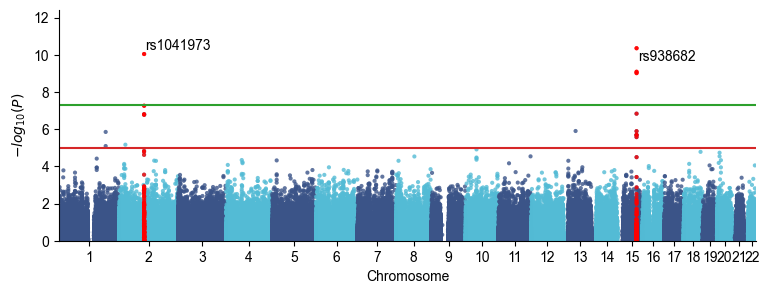

In [23]:
from qmplot import manhattanplot, qqplot

plt.figure(figsize=(20,15))
manhattanplot(snps, chrom='CHR', pos='BP', snp='SNP',
              sign_marker_p=sig,
              is_annotate_topsnp=True,
              ld_block_size=500000)
plt.savefig('Plots/manhattan.png', dpi=300)

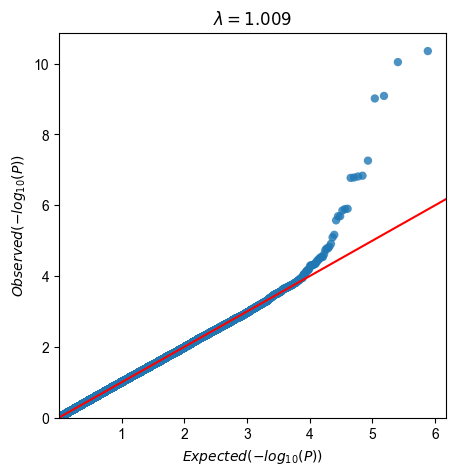

In [24]:
qqplot(snps['P'])
plt.savefig('Plots/qq.png', dpi=300)

Since everything seems good and it doesn't seems to be population stratification, we extract the significant SNPs to conduct further investigation

In [72]:
snps[snps['P']<sig]


,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
228115,2,rs1041973,102955468,A,ADD,1363,0.5571,-6.482,9.066000e-11
228205,2,rs10197310,103020030,A,ADD,1355,0.5821,-5.434,5.501000e-08
1599985,15,rs569207,78873119,A,ADD,1367,0.5679,-6.115,9.645000e-10
1599990,15,rs938682,78896547,G,ADD,1349,0.5394,-6.589,4.421000e-11
1599995,15,rs6495308,78907656,G,ADD,1367,0.5647,-6.141,8.184000e-10


In [74]:
snps[snps['P']<sig].to_csv('SignificativeSNPS.tsv', sep='\t', index=False)